In [111]:
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics
import numpy as np
import pandas as pd
import scipy.io
from tensorflow import keras as K, nn
import seaborn as sns
from keras.regularizers import l2

# Load dataset of our own handwritten letters

In [112]:
# Load all char datasets of own handwriting to create larger dataset
# chars1, chars2, chars3

data1 = np.load('data/training/chars1.npy')
data2 = np.load('data/training/chars2.npy')
data3 = np.load('data/training/chars3.npy')

np.concatenate
data_total = np.concatenate((data1, data2, data3))
data_total.shape

(77, 28, 28)

## Normalize data

In [113]:
data = data_total/255



## Initialized once
# y = np.empty(data.shape[0], dtype=np.uint8)
y = np.array([7,14,15,4,19,7,8,18,22,99,10,18,99,5,11,13,0,15,17,14,9,4,2,19
,19,7,8,18,8,18,0,99,12,15,11,4,99,23,19,19,7,4,99,99,14,13,99,17
,8,15,19,0,19,7,8,17,3,11,8,13,4,99,19,4,23,19,5,8,13,0,11,12
,4,18,18,0,99])

## Labelling data

In [114]:
chars = 'abcdefghijklmnopqrstuvwxyz'
## Unrecognized character gives 99
def encode_char(x):
    try:
        i = chars.index(x)
        return i
    except ValueError:
        return 99

[ 7 14 15  4 19  7  8 18 22 99 10 18 99  5 11 13  0 15 17 14  9  4  2 19
 19  7  8 18  8 18  0 99 12 15 11  4 99 23 19 19  7  4 99 99 14 13 99 17
  8 15 19  0 19  7  8 17  3 11  8 13  4 99 19  4 23 19  5  8 13  0 11 12
  4 18 18  0 99]


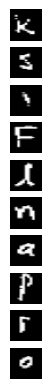

In [115]:
fig, axes = plt.subplots(10)
for i in range(10,20):
    axes[i%10].imshow(data[i,:,:], cmap = "gray")
    axes[i%10].axis('off')

# Manually set labels...
# labels = 'e,-,t,e,x,t,f,i,n,a'.split(',')
# y[60:70] = [encode_char(x) for x in labels]
#print(np.shape(y))
print(y)

## Show data

Char dataset shape:  (77, 28, 28)


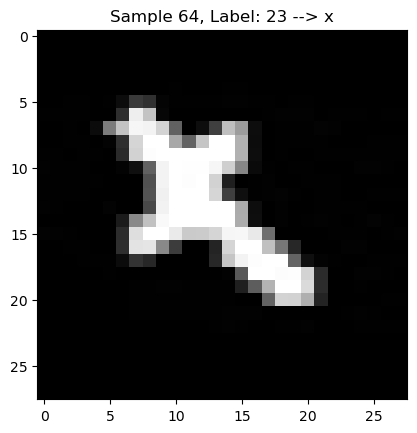

In [116]:
print("Char dataset shape: ", data.shape)
k = np.random.randint(0, len(data))
char = data[k,:,:]
plt.imshow(char, cmap='gray')
label = y[k,]

if label == 99:
    true_char = 'unknown'
else:
    true_char = chars[label]

plt.title('Sample ' + str(k) + ', Label: '+ str(label) + ' --> ' + str(true_char));

# Load EMNIST dataset

In [117]:
emnist = scipy.io.loadmat('data/training/emnist-letters.mat')
emnist_data = emnist['dataset']

X_train = emnist_data['train'][0,0]['images'][0,0]
y_train = emnist_data['train'][0,0]['labels'][0,0]

X_test = emnist_data['test'][0,0]['images'][0,0]
y_test = emnist_data['test'][0,0]['labels'][0,0]

## Create validation set
# val_start = X_train.shape[0] - X_test.shape[0]
# X_val = X_train[val_start:X_train.shape[0],:]
# y_val = y_train[val_start:X_train.shape[0]]
# X_train = X_train[0:val_start,:]
# y_train = y_train[0:val_start]


print("X train shape: ", X_train.shape)
print("y train shape: ", y_train.shape)
print("X test shape: ", X_test.shape)
print("y test shape: ", y_test.shape)

# print("X validation shape: ", X_val.shape)
# print("y validation shape: ", y_val.shape)

# Scale data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
#y_train = scaler.fit_transform(y_train)
X_test = scaler.fit_transform(X_test)
#y_test = scaler.fit_transform(y_test)

X train shape:  (124800, 784)
y train shape:  (124800, 1)
X test shape:  (20800, 784)
y test shape:  (20800, 1)


Text(0.5, 1.0, 'Test Label: y, 25')

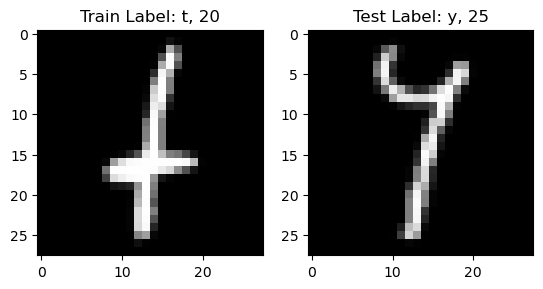

In [118]:
X_train = X_train.reshape((X_train.shape[0], 28, 28), order='F')
X_test = X_test.reshape((X_test.shape[0], 28, 28), order='F')

rand_train = np.random.randint(0, len(X_train))
rand_test = np.random.randint(0, len(X_test))

train_char = X_train[rand_train,:,:]
test_char = X_test[rand_test,:,:]

train_label_i = y_train[rand_train,0]
test_label_i = y_test[rand_test,0]
# Translate labels to letter
letters = 'abcdefghijklmnopqrstuvwxyz'
train_label = letters[train_label_i-1]
test_label = letters[test_label_i-1]

fig, axes = plt.subplots(1,2)
axes[0].imshow(train_char, cmap='gray')
axes[0].set_title(f'Train Label: {train_label}, {train_label_i}')
#plt.title(f'Label: {label}, {label_i}')
axes[1].imshow(test_char, cmap='gray')
axes[1].set_title(f'Test Label: {test_label}, {test_label_i}')

In [119]:
# X_test = X_test.reshape((X_test.shape[0], 28, 28), order='F')

# random_sample = np.random.randint(0, len(X_test))
# char = X_test[random_sample,:,:]
# label_i = y_test[random_sample,0]
# # Translate labels to letter
# letters = 'abcdefghijklmnopqrstuvwxyz'
# label = letters[label_i-1]

# plt.imshow(char, cmap='gray')
# plt.title(f'Label: {label}, {label_i}')



# Pre-training with EMNIST dataset

In [120]:
# Add channel dimension
X_train = X_train.reshape((X_train.shape[0],28,28,1))
X_test = X_test.reshape((X_test.shape[0],28,28,1))


model = K.models.Sequential([
    K.layers.Conv2D(48, (4,4), activation='relu', input_shape=X_train.shape[1:]),
    K.layers.MaxPool2D((2,2)),
    K.layers.Conv2D(24, (3,3), activation='relu'),
    K.layers.MaxPool2D((2,2)),
    K.layers.Dropout(0.15),
    K.layers.Flatten(),
    K.layers.Dense(42, activation='relu',kernel_regularizer=l2(0.05)),
    K.layers.Dense(37, activation='relu',kernel_regularizer=l2(0.05)), #kernel_regularizer=l2(0.05)
    K.layers.Dense(len(letters) + 1, activation='softmax')
])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 25, 25, 48)        816       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 12, 12, 48)        0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 10, 10, 24)        10392     
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 5, 5, 24)          0         
 ng2D)                                                           
                                                                 
 dropout_11 (Dropout)        (None, 5, 5, 24)          0         
                                                                 
 flatten_11 (Flatten)        (None, 600)             

In [121]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=1000, verbose=2, validation_data=(X_test, y_test))

Epoch 1/10
125/125 - 22s - loss: 4.2252 - accuracy: 0.4070 - val_loss: 1.8948 - val_accuracy: 0.7178 - 22s/epoch - 174ms/step
Epoch 2/10
125/125 - 21s - loss: 1.5106 - accuracy: 0.7566 - val_loss: 1.1427 - val_accuracy: 0.8223 - 21s/epoch - 165ms/step
Epoch 3/10
125/125 - 21s - loss: 1.0522 - accuracy: 0.8159 - val_loss: 0.8848 - val_accuracy: 0.8492 - 21s/epoch - 165ms/step
Epoch 4/10
125/125 - 21s - loss: 0.8655 - accuracy: 0.8393 - val_loss: 0.7651 - val_accuracy: 0.8605 - 21s/epoch - 167ms/step
Epoch 5/10
125/125 - 21s - loss: 0.7670 - accuracy: 0.8497 - val_loss: 0.7077 - val_accuracy: 0.8640 - 21s/epoch - 168ms/step
Epoch 6/10
125/125 - 21s - loss: 0.6993 - accuracy: 0.8585 - val_loss: 0.6364 - val_accuracy: 0.8750 - 21s/epoch - 168ms/step
Epoch 7/10
125/125 - 21s - loss: 0.6458 - accuracy: 0.8656 - val_loss: 0.5961 - val_accuracy: 0.8792 - 21s/epoch - 166ms/step
Epoch 8/10
125/125 - 21s - loss: 0.6146 - accuracy: 0.8680 - val_loss: 0.5662 - val_accuracy: 0.8841 - 21s/epoch - 167

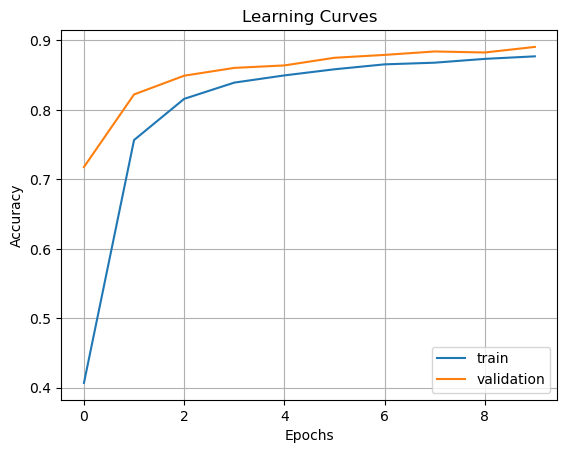

In [129]:
plt.title('Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.grid()
plt.show()

In [130]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Accuracy: {accuracy*100}')

Accuracy: 89.06731009483337


# Predict our own handwritten characters

In [131]:
data = data.reshape(data.shape[0],28,28,1)
# make prediction
proba = model.predict(data, verbose = 0)
pred = [np.argmax(p) for p in proba]


pred_chars = [chars[x-1] for x in pred]
pred_chars

['a',
 'o',
 'p',
 'c',
 't',
 'h',
 'j',
 'g',
 'w',
 'm',
 'k',
 's',
 't',
 'f',
 'i',
 'n',
 'a',
 'p',
 'r',
 'o',
 'j',
 'e',
 'e',
 'b',
 't',
 'n',
 'f',
 't',
 'i',
 'e',
 'a',
 'm',
 'm',
 'r',
 'i',
 'e',
 'w',
 'x',
 'e',
 'i',
 'n',
 'c',
 'y',
 'm',
 't',
 'm',
 'z',
 'i',
 'i',
 'p',
 'e',
 'a',
 't',
 'n',
 'i',
 'r',
 'b',
 'i',
 'i',
 'n',
 'c',
 'a',
 'b',
 'r',
 'x',
 'e',
 'f',
 'i',
 'n',
 'a',
 'i',
 'm',
 'e',
 's',
 'f',
 'a',
 'f']

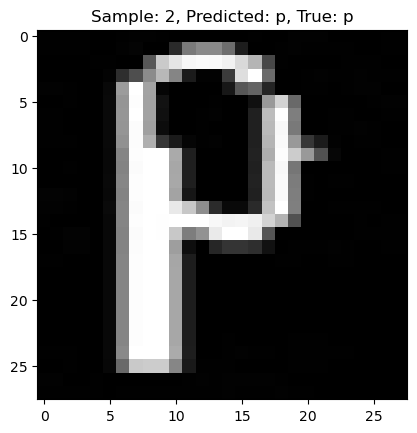

In [132]:
data = data.reshape(data.shape[0],28,28)
k = np.random.randint(0,len(pred_chars))

label = y[k]
if label == 99:
    true_char = 'unknown'
else:
    true_char = chars[label]

plt.imshow(data[k,:,:], cmap='gray')
plt.title(f"Sample: {k}, Predicted: {pred_chars[k]}, True: {true_char}");

## Confusion Matrix

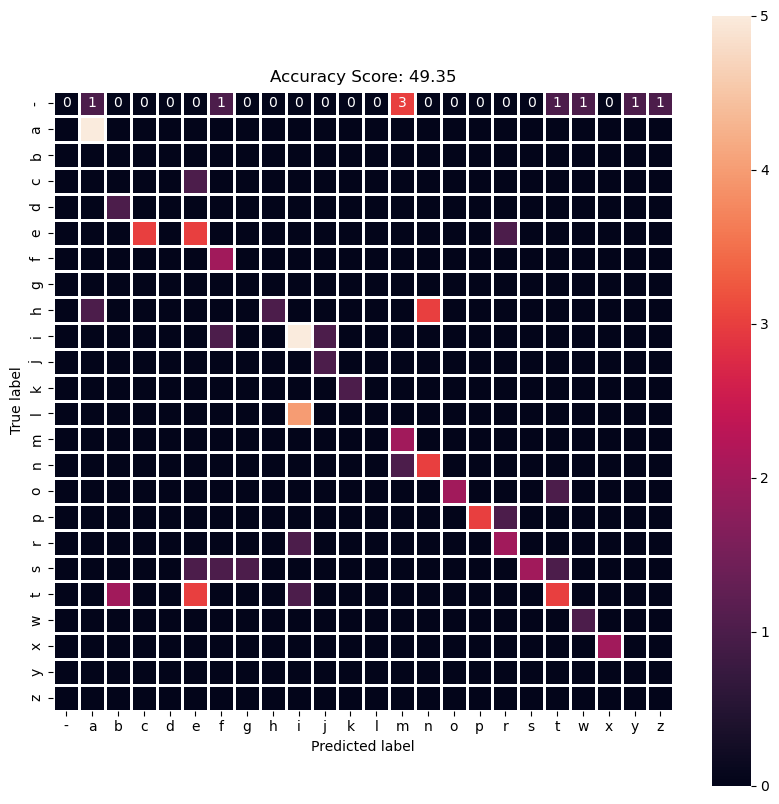

In [133]:
def to_char(index):
    if index == 99:
        return '-'
    else:
        return chars[index]

y_true = [to_char(x) for x in y]
y_pred = pred_chars

## Locate misclassified characters
df = pd.DataFrame(columns=['Pred', 'True'])
df.loc[:,'True'] = y_true
df.loc[:,'Pred'] = y_pred
misclassified = df[df['Pred'] != df['True']]
acc = 1-(len(misclassified)/len(y_pred))

## Confusion matrix
set_total = set(y_pred).union(set(y_true))
labels = sorted(list(set_total))

cm = metrics.confusion_matrix(y_true, y_pred)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=1, square=True);
plt.ylabel('True label');
plt.xlabel('Predicted label');
plt.title('Accuracy Score: {0:.2f}'.format(acc*100), size=12);
ax.set_xticklabels(labels);
ax.set_yticklabels(labels);

In [127]:
print(f"Misclassified: {len(misclassified)}")
misclassified

Misclassified: 39


,Pred,True
0,a,h
3,c,e
6,j,i
7,g,s
9,m,-
12,t,-
14,i,l
22,e,c
23,b,t
25,n,h


In [128]:
## Dictionary with frequency of misclassified characters
dict = {}
for i in range(0,len(misclassified)):
    pred = misclassified.iloc[i,0]
    dict[pred] = dict.get(pred,0) + 1
dict

{'a': 2,
 'c': 3,
 'j': 1,
 'g': 1,
 'm': 4,
 't': 3,
 'i': 6,
 'e': 5,
 'b': 3,
 'n': 3,
 'f': 3,
 'r': 2,
 'w': 1,
 'y': 1,
 'z': 1}